In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
def voisins(G, case):
    """Renvoie les coordonnées des cases voisines dont le temps de trajet n'a pas encore été calculé dans la grille G.

    Args:
        G (2D array) : grille contenant les temps de trajet
        case (tuple) : coordonnées (i,j) de la case dont on veut connaître les voisins
        
    Returns:
        v (list): liste de tuple contenant les coordonnées des voisins
        
    """

    i, j = case 
    voisins = [ (i,j-1), (i-1,j), (i,j+1), (i+1,j) ] 
    #on déclare la liste des voisins d'un élément qui n'est pas au bord du tableau (il a maximum 4 voisins)
    
    return [ v for v in voisins if (0 <= v[0] < G.shape[0]) and (0 <= v[1] < G.shape[1]) 
            and (G[v] != 10000) and (type(G[v]) != np.ma.core.MaskedConstant) ] 

    #liste en compréhension pour faire le tri avec 3 critères :
    #- ne pas sortir du tableau
    #- le temps de trajet a été calculé donc il est différent de 10000
    #- la case ne correspond pas à un obstacle (case avec un mask)

In [3]:
def voisins_sep(G, case):
    """ Cette fonction permet de récupérer les coordonnées des voisins d'une case en séparant les voisins 
        verticaux (selon i) et horizontaux (selon j). En effet on ne prend pas en compte les voisins situés sur la diagonale.
    
    Args:
        G (2D array) : grille contenant les temps de trajet
        case (tuple) : coordonnées (i,j) de la case dont on veut connaître les voisins   
                      
    Returns:
        v_i, v_j (tuple) : tuple contenant 2 listes et chaque liste contient les coordonnées des voisins :
                                - la 1ère correspond aux voisins verticaux
                                - la 2ème correspond aux voisins horizontaux
        
    """
    
    i, j = case
    voisins_i = [ (i-1,j) , (i+1,j) ]  #maximum 2 voisins selon chaque direction
    voisins_j = [ (i,j-1) , (i,j+1) ] 
    
    v_i = [v for v in voisins_i if (0<=v[0]<G.shape[0]) and (0<=v[1]<G.shape[1]) and (type(G[v])!=np.ma.core.MaskedConstant)]
    v_j = [v for v in voisins_j if (0<=v[0]<G.shape[0]) and (0<=v[1]<G.shape[1]) and (type(G[v])!=np.ma.core.MaskedConstant)]
    
    return v_i, v_j

    #pour chaque direction, on sélectionne les voisins avec une liste en compréhension selon 2 critères : 
    #   - ils ne doivent pas sortir de la grille G
    #   - ils ne doivent pas être un obstacle et donc ne pas avoir ce type masqué "np.ma.core.MaskedConstant"

In [4]:
def calcul_F(case, T, ind, people, h, f):
    """Fonction qui calcule la valeur de F pour la case considérée au temps T. Cette valeur nous intéresse pour le mouvement 
       d'un certain individu et elle va dépendre des autres individus présents sur la grille. 
       
    Args:
        case (tuple) : coordonnées (i,j) de la case
        T (float) : instant considéré
        ind (int) : indice de l'individu qui nous intéresse pour le retrouver dans le tableau people 
        people (2D array) : tableau contenant les informations sur les individus présents
        h (float) : dimension d'une cellule
        f (float) : valeur de F à assigner si quelqu'un est présent sur la case 
    
    Returns:
        F (float) : valeur de F pour cette case 

    """
    
    i, j = case
    F = 1  #par défaut
    
    for n in range(people.shape[0]):  #on parcourt le tableau people pour repérer la position de tous les personnages 
        if n != ind:  #sauf l'individu concerné 
            individu = people[n]  
            ic, jc, R, vi, vj = individu[0], individu[1], individu[2], individu[3], individu[4]
            new_i = (ic + vi*T)/h  #nouvelle position
            new_j = (jc + vj*T)/h
            if np.sqrt( (new_i-i)**2 + (new_j-j)**2 ) <= R:  #distance entre nouvelle position et la case qu'on évalue
                F = f
    
    return F
            

In [5]:
def travelTime(G, case, F, h):
    """Calculer le temps de trajet pour une case dans la grille G.
    
    Args:
        G (2D array) : grille contenant les temps de trajet
        case (tuple) : coordonnées (i,j) de la case considérée 
        F (float) : valeur de F pour cette case
        h (float) : dimension d'une cellule
        
    Returns:
        T (float) : temps de trajet 
   
    """
    
    #gradient dans la direction verticale
    voisins_i = voisins_sep(G, case)[0]
    
    if len(voisins_i) == 0:
        grad_i = 0
    
    else:
        if len(voisins_i) == 1:
            a = G[voisins_i[0]]
        else:
            a = np.min([ G[voisins_i[0]] , G[voisins_i[1]] ])
    
        grad_i = np.max([ 0, (G[case]-a)/h ])
    
        
    #gradient dans la direction horizontale
    voisins_j = voisins_sep(G, case)[1]
    
    if len(voisins_j) == 0:
        grad_j = 0
    
    else:
        if len(voisins_j) == 1:
            b = G[voisins_j[0]]
        else:
            b = np.min([ G[voisins_j[0]] , G[voisins_j[1]] ])
    
        grad_j = np.max([ 0, (G[case]-b)/h ])
     

    #3 cas différents qui nous donnent 3 calculs différents pour déterminer T
    if grad_i == 0:
        T = (h/F) + b  
        
    elif grad_j == 0:
        T = (h/F) + a
        
    else:
        T = 0.5*( a+b + np.sqrt( 2*(h/F)**2 - (a-b)**2 ) )

    return T 


In [6]:
def update_NB(G, NB_actuelle, min_NB):
    """ Cette fonction va mettre à jour la Narrow Band actuelle en effectuant quelques modifications :
            - retirer le minimum de la Narrow Band actuelle car on va l'étendre 
            - ajouter les nouveaux voisins extérieurs
            - enlever les doublons
            
    Args:
        G (2D array) : grille contenant les temps de trajet
        NB_actuelle (list) : Narrow Band actuelle 
        min_NB (tuple) : minimum de la Narrow Band actuelle qui nous permet de l'étendre
        
    Returns:
        new_NB (list) : nouvelle Narrow Band 
        
            
    """
    
    NB_actuelle.remove(min_NB)  #on retire le minimum 
    voisins = voisins_sep(G, min_NB)[0] + voisins_sep(G, min_NB)[1]  #on veut tous les voisins donc on prend les 2 directions
    new_NB = NB_actuelle + [v for v in voisins if G[v] == 10000 ] 
    #on veut ajouter seulement les voisins extérieurs donc ceux non calculés (ils valent 10000)
    
    return list(set(new_NB))  #on renvoie la liste sans doublons


In [7]:
def makeGrid(shape, ind, people):
    """Génère une grille de dimensions shape et met l'objectif à la position initiale de l'individu concerné.
    
    Args:
        shape (tuple): (nombres de lignes, nombre de colonnes) dimensions du tableau 
        ind (int) : indice de l'individu dans le tableau people
        people (2D array) : tableau contenant les informations sur les individus présents 
        
    Returns:
        G (2D array): tableau rempli de 10000 sauf à l'objectif où on met 0
 
    """
    G = 10000*np.ones(shape)
    individu = people[ind]  #on récupère les informations de l'individu dans le tableau people
    i, j = individu[0], individu[1]
    G[i,j] = 0
    
    return G


In [8]:
def fastMarching(G, ind, people, h, f, dt):
    """Algorithme de fast marching qui calcule tous les temps de trajet d'une grille pour un individu.
    
    Args:
        G (2D array) : grille contenant les temps de trajet
        ind (int) : indice de l'individu concerné
        people (2D array) : tableau contenant les informations sur les individus présents
        h (float) : dimension d'une cellule
        f (float) : valeur de F si quelqu'un est sur la case
        dt (float) : temps utilisé pour l'estimation du temps avant le calcul de F
        
    Returns:
        G (2D array) : grille contenant à la fin tous les temps de trajet calculés pour l'individu
        F_tab (2D array) : tableau avec les valeurs de F à la fin
            
    """
    
    F_tab = np.zeros(G.shape)  #on initialise le tableau de F à 0 
   
    objectif = np.where(G == 0)
    O = ( objectif[0][0] , objectif[1][0] )  #on repère l'objectif
    
    F_tab[O] = 1  
    
    NB = voisins_sep(G,O)[0] + voisins_sep(G,O)[1]  #la première Narrow Band correspond aux voisins de l'objectif

    
    while (G == 10000).any() == True:  #tant que tout n'est pas calculé (tant qu'il reste un élément à 10000)
    
        temps_NB = []  #on construit la liste contenant les temps de trajet de la Narrow Band
        for case in NB:
            voisins_list = voisins(G, case)   #estimation du temps de trajet avec les temps voisins
            liste_valeur = [] 
            for v in voisins_list:
                liste_valeur.append(G[v])
        
            i_max = liste_valeur.index(max(liste_valeur))  #on prend le maximum
            coord_max = voisins_list[i_max]  
            t_max = G[coord_max] + dt  #temps maximum + dt
            
            if F_tab[case] == 0:     #si F n'a pas été calculé pour cette case 
                F = calcul_F(case, t_max, ind, people, h, f)   #on le calcule 
                F_tab[case] = F   #on complète le tableau F
            else:
                F = F_tab[case]    #si F a déjà été calculé, la valeur reste la même 
            
            t = travelTime(G, case, F, h)  #on calcule le temps de trajet avec la valeur de F calculée
            temps_NB.append(t)  #on l'ajoute à la liste
    
        i_min = temps_NB.index(min(temps_NB))  #on récupère l'indice du minimum de la liste contenant les temps de trajet 
        coord_min = NB[i_min]  #on voit a quelle case ça correspond dans la NB    

        G[coord_min] = min(temps_NB)  #on remplace dans la grille G par le temps de trajet calculé

        NB = update_NB(G, NB, coord_min)  #on met à jour la Narrow Band 
     
    
    return G, F_tab


In [9]:
def Graphes(G):
    """Trace deux graphes pour représenter l'évolution du temps de trajet dans la grille G."""
    
    #représente la grille avec une échelle de couleur pour les temps de trajet
    fig = plt.figure( figsize = (13, 8) )
    im = plt.imshow( G, origin='lower', extent=[0, G.shape[0], 0, G.shape[1]])
    plt.xlabel('colonnes (j)')
    plt.ylabel('lignes (i)')
    c = fig.colorbar(im)
    c.set_label('Temps de trajet')
    
    #représente les contours
    fig, ax = plt.subplots( figsize = (12,9) ) 
    CS = ax.contour( G, levels = np.arange(1, int(np.max(G))) )
    ax.clabel(CS, inline=1, fontsize=10)
    ax.set_xlabel('colonnes (i)')
    plt.title("Lignes de niveau pour les temps de trajet entre un point et l'objectif")
    ax.set_ylabel('lignes (i)')

    plt.show()

Tableau people : chaque individu est défini par 5 paramètres et il correspond à une ligne du tableau people (autrement dit son numéro est égal à l'indice de la ligne dans people)

un individu = (ic, jc, R, vi, vj)

- ic : indice de la ligne où se situe le centre de l'individu
- jc : indice de la colonne où se situe le centre de l'individu
- R : rayon de l'individu
- vi : composante verticale de la vitesse de l'individu (comment il change de ligne)
- vj : composante horizontale de la vitesse de l'individu (comment il change de colonne)


In [10]:
#Conditions initiales
people = np.array([ [0,5,1,1,0] , [4,9,1,0,-1] ])
shape = (10,10)
ind = 0  #on choisit l'individu dont on veut étudier la trajectoire 
G = makeGrid(shape, ind, people)

#paramètres
h=1
f=0.1
dt=1

In [11]:
A = fastMarching(G, ind, people, h, f, dt)

In [12]:
grid = A[0]
F_tab = A[1]

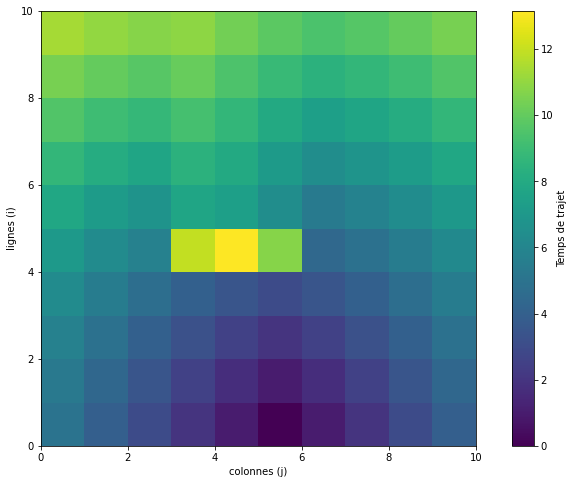

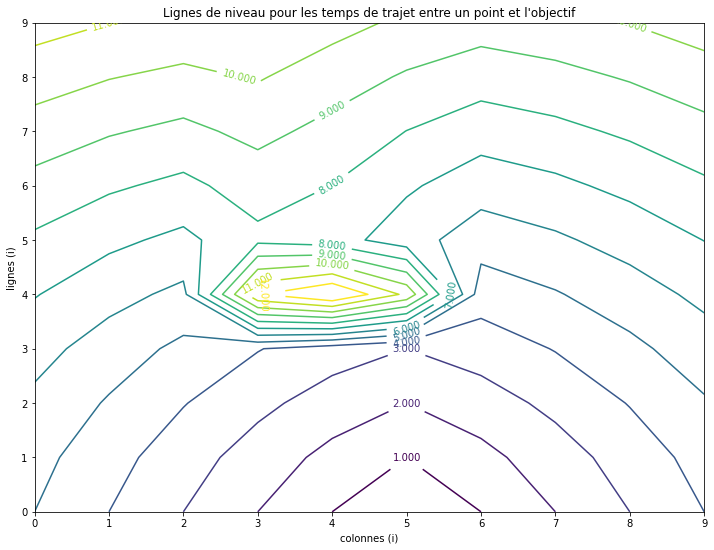

In [13]:
Graphes(grid)

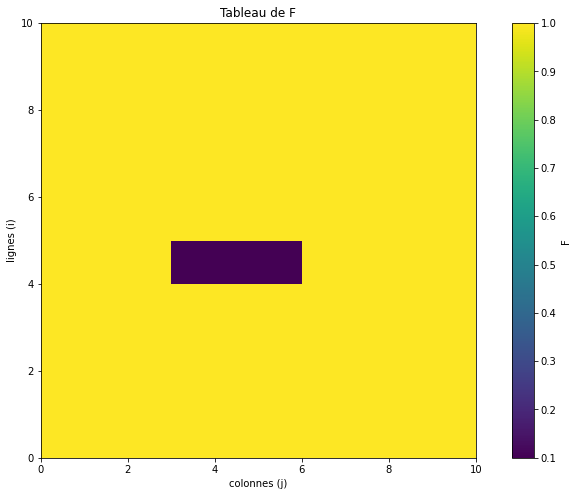

In [14]:
fig = plt.figure( figsize = (13, 8) )
im = plt.imshow( F_tab, origin='lower', extent=[0, F_tab.shape[0], 0, F_tab.shape[1]])
plt.xlabel('colonnes (j)')
plt.ylabel('lignes (i)')
plt.title("Tableau de F")
c = fig.colorbar(im)
c.set_label('F')

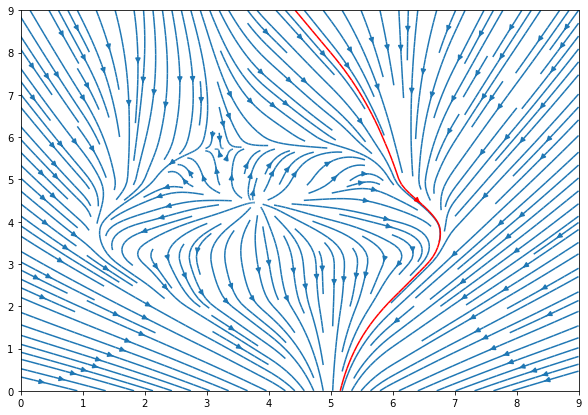

In [15]:
#Streamline

vx = -np.gradient(grid)[0]
vy = -np.gradient(grid)[1]
x = np.arange(10)
y = x

start = [[5,8]]   #porte à atteindre 

fig = plt.figure( figsize = (10, 7) )
plt.streamplot(x, y, vy, vx, density=2)
plt.streamplot(x, y, vy, vx, density=2, linewidth=None, color='r', start_points=start)

plt.show()